In [2]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
data=pd.read_csv("C:\\Users\\GV62\\Downloads\\train.csv")
test_data = pd.read_csv("C:\\Users\\GV62\\Downloads\\test.csv")
data.head(5)


,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [7]:
test_data.head(5)

,id,url
0,cb9998b8cdaf6235,https://lh3.googleusercontent.com/-q8B91vDIQZY...
1,30728cf6e50a6bc6,https://lh3.googleusercontent.com/-91gJSKTgv5Q...
2,16afbc86b710337d,https://lh3.googleusercontent.com/-GHZdXuf2wMg...
3,d29b2166cf522450,https://lh3.googleusercontent.com/-cWDnYNQhyws...
4,dd5c03b20c21cfba,https://lh3.googleusercontent.com/-PSLN6BloM-k...


# Sample the data

In [11]:
landmark_list = [str(x) for x in list(range(1000,3000))]
data_sample = data[data['landmark_id'].isin(landmark_list)]#Make a data sample that contains all tuples that have landmark_id b/w 1000 and 3000
data_sample.head()

,id,url,landmark_id
27,59be77be1d452a4f,https://lh5.googleusercontent.com/--Q3SMs25zX8...,1472
30,8d366770a87778b8,http://lh5.ggpht.com/-Kbr17owtR3Q/SYtzNSaYiRI/...,2157
34,fdbac32ad9bbf6e5,https://lh4.googleusercontent.com/-r_X8PoYuZGs...,2449
44,823d46dc9a83ac71,http://lh5.ggpht.com/-ACjGX7p_wEU/RqDzUZFvNVI/...,1168
45,06a2c21c0e283d3e,https://lh3.googleusercontent.com/-3j3UkLr6_kI...,1287


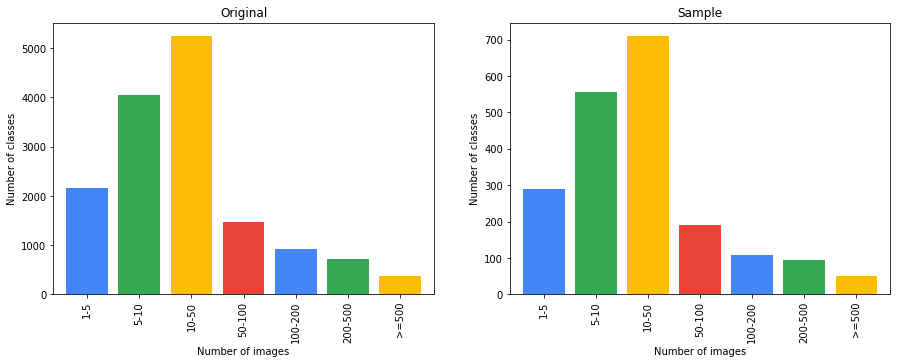

In [13]:
#To Check data distribution i.e. making sure that the distribution of classes is equivalent to the original dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)

In [14]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

'''Split to test and train'''
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.01 #takes 1% from each class as holdout
import random
random.seed(42)
for landmark_id in set(data_sample_resize['landmark_id']):
    n=1
    t = data_sample_resize[(data_sample_resize.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample_resize[data_sample_resize.id.isin(test)] #holdout dataset
    data_tr = data_sample_resize[data_sample_resize.id.isin(training)] #training dataset
    data_test = data_test.append(data_t)  
    data_training_all = data_training_all.append(data_tr)
    n+=1

print ('2. train and test set created')


'''Split into train and validation set'''
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')

1. URLs overwritten
2. train and test set created
3. train and validation set created


In [15]:
print (len(data_train))
print (len(data_valid))
print (len(data_test))

130515
31642
1183


In [30]:
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    with open('D:\\CNNStuff\\Data\\' + folder + '\\image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
    
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
i=0
for link in data_train['url']:              #looping over links to get images
    if os.path.exists('D:\\CNNStuff\\Data\\train_images_model'+str(data_train['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'train_images_model')
    os.rename('D:\\CNNStuff\\Data\\train_images_model\\image.jpg','D:\\CNNStuff\\Data\\train_images_model\\'+ str(data_train['id'].iloc[i])+ '.jpg')
    i+=1
    if(i==50):   #uncomment to test in your machine
         break
print('4. train images fetched')

    
i=0
for link in data_valid['url']:              #looping over links to get images
    if os.path.exists('D:\\CNNStuff\\Data\\validation_images_model'+str(data_valid['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'validation_images_model')
    os.rename('D:\\CNNStuff\\Data\\validation_images_model\\image.jpg','D:\\CNNStuff\\Data\\validation_images_model\\'+ str(data_valid['id'].iloc[i])+ '.jpg')
    i+=1
    if(i==50):   #uncomment to test in your machine
         break
print('5. Validation images fetched')
i=0
for link in data_test['url']:              #looping over links to get images
    if os.path.exists('D:\\CNNStuff\\Data\\test_images_from_train\\'+str(data_test['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'test_images_from_train')
    os.rename('D:\\CNNStuff\\Data\\test_images_from_train\\image.jpg','D:\\CNNStuff\\Data\\test_images_from_train\\'+ str(data_test['id'].iloc[i])+ '.jpg')
    i+=1
    if(i==50):   #uncomment to test in your machine
         break
print('6. Test images fetched')

4. train images fetched
5. Validation images fetched
6. Test images fetched


In [31]:
##create folders for landmark IDs in Training folder
import pandas as pd
import os
import shutil
from shutil import copyfile
import urllib

train_data = data_train

temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = 'D:\\CNNStuff\\Data\\' + folder + '\\'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1
createfolders(temp,'train_images_model')
print ('Train folders created')

rootdirpics = r'D:\\CNNStuff\\Data\\train_images_model\\'
rootdirfolders = r'D:\\CNNStuff\\Data\\train_images_model\\'
def transformdata(data,path1, path2):

    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >1000)):
#                 print('move')
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 1000)):
                os.remove(inpath)
        n+=1

transformdata(train_data,rootdirpics, rootdirfolders)
print ('Train images moved')

Train folders created
Train images moved


In [36]:
##create folders for landmark IDs in Validation folder

temp = pd.DataFrame(data_valid.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
createfolders(temp,'validation_images_model')
print ('Validation folders created')

#make folders for landmark ID which had no images in validation sets - required for codes running next
available = [int((x[0].split('\\'))[-1]) for x in os.walk(r'D:\\CNNStuff\\Data\\validation_images_model\\') if len((x[0].split('\\'))[-1]) > 0]
new = [str(x) for x in range(1000,2999) if x not in available]
for i in new:
    path = 'D:\\CNNStuff\\Data\\validation_images_model\\' + i
    if not os.path.exists(path):
        os.makedirs(path)

rootdirpics = r'D:\\CNNStuff\\Data\\validation_images_model\\'
rootdirfolders = r'D:\\CNNStuff\\Data\\validation_images_model\\'
transformdata(data_valid,rootdirpics, rootdirfolders)
print ('Validation images moved')

Validation folders created
Validation images moved


In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

def displayLandmarkImagesLarge(urls, category_name):
    img_style = "width: 200px; height:160px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

category = data['landmark_id'].value_counts().keys()[15]
urls = data[data['landmark_id'] == category]['url']
displayLandmarkImagesLarge(urls, "")

In [4]:
# Visualize 6 images for each of the first 4 landmarks, ordered by the number of occurences.
LANDMARK_NUMBER = 4
IMAGES_NUMBER = 6
landMarkIDs = pd.Series(data['landmark_id'].value_counts().keys())[0:LANDMARK_NUMBER]
for landMarkID in landMarkIDs:
    url = data[data['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url, "")

In [5]:
pd.Series(data['landmark_id'].value_counts().keys())[1:4]

1    6051
2    6599
3    9779
dtype: object

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model =VGG16(weights = 'imagenet', include_top = True)

img_path = r'D:\CNNStuff\Data\train_images_model\2290\a13d7302a957996f.jpg'
img = image.load_img(img_path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top = 3)[0])

# 0a0667fc2436a04b = stupa (17%)
# 0b48dd3b81d5b6ba = triumphal_arch(25%)

40960/35363 [==================================] - 0s 7us/step
Predicted: [('n04486054', 'triumphal_arch', 0.1322437), ('n03781244', 'monastery', 0.0921237), ('n02825657', 'bell_cote', 0.082534045)]
